# Event selection and map computation for low background data

## This NB: 

- Selects events.

- Checks run conditions are normal.

- Computes XY maps.


### Checking valid only for low background physics runs:

Values are taken from the LBphysics configuration file.

In [ ]:
! cd $HOME/ICAROS; git remote add mmkekic https://github.com/mmkekic/ICAROS.git; git fetch mmkekic; git checkout mmkekic/clean_krcalib; cd -;

## Imports

In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt

from krcal.map_builder.map_builder_functions  import load_data
from krcal.map_builder.map_builder_functions  import check_rate_and_hist
from krcal.map_builder.map_builder_functions  import selection_nS_mask_and_checking
from krcal.core.kr_types                      import type_of_signal
from krcal.map_builder.map_builder_functions  import check_Z_dst
from krcal.map_builder.map_builder_functions  import band_selector_and_check
from krcal.map_builder.map_builder_functions  import get_binning_auto
from krcal.map_builder.map_builder_functions  import calculate_map
from krcal.core.kr_types                      import FitType
from krcal.core.selection_functions           import selection_in_band

from krcal.map_builder.map_builder_functions  import check_failed_fits
from krcal.map_builder.map_builder_functions  import regularize_map
from krcal.map_builder.map_builder_functions  import remove_peripheral
from krcal.map_builder.map_builder_functions  import add_krevol
from invisible_cities.reco.corrections_new    import read_maps

from krcal.core.io_functions                  import write_complete_maps
from krcal.core.selection_functions           import get_time_series_df

In [2]:
from krcal.NB_utils       .xy_maps_functions     import draw_xy_maps
from krcal.core       .map_functions         import relative_errors
from krcal.core       .map_functions         import add_mapinfo

In [3]:
from krcal.NB_utils.plt_functions                import plot_s1histos
from krcal.NB_utils.plt_functions                import s1d_from_dst
from krcal.NB_utils.plt_functions                import plot_s2histos
from krcal.NB_utils.plt_functions                import s2d_from_dst
from krcal.core.correction_functions  import e0_xy_correction

from krcal.NB_utils.fit_energy_functions          import fit_energy
from krcal.NB_utils.plt_energy_functions          import  plot_fit_energy, print_fit_energy



In [4]:
from krcal.NB_utils.plt_functions import plot_time_fcs
from invisible_cities.reco.corrections_new import apply_all_correction
from krcal.NB_utils.plt_functions            import h1, h2,  profile1d, plot_histo, plot_selection_in_band
from krcal.core.histo_functions            import profile1d
from krcal.NB_utils.plt_energy_functions          import resolution_r_z, plot_resolution_r_z


In [5]:
import logging
import warnings
warnings.filterwarnings("ignore")
logging.disable(logging.DEBUG)
this_script_logger = logging.getLogger(__name__)
this_script_logger.setLevel(logging.INFO)

## Files

In [6]:
run_number = 7546

In [ ]:
! wget https://www.dropbox.com/s/3ky8js2yekh4sqw/kr_emap_xy_100_100_r_6573_time.h5
! wget https://www.dropbox.com/s/5n9gj9wjcz70na7/z_dst_LB_mean_ref.h5
! wget https://www.dropbox.com/s/hghderot5uv5gu1/kdst_7546_v1.1.0_20190801_krbg.h5

In [7]:
folder_dst       = './'
dst_file         = 'kdst_{0}_v1.1.0_20190801_krbg.h5'.format(run_number)
output_maps_file = './'
map_file_out     = os.path.join(output_maps_file, 'map_{0}.h5'.format(run_number)   )
histo_file_out   = os.path.join(output_maps_file, 'histos_{0}.h5'.format(run_number))

print('Input dst: ', folder_dst + dst_file)
print('Output map file: ', map_file_out)
print('Output histograms file: ', histo_file_out)

Input dst:  ../kdst_7546_v1.1.0_20190801_krbg.h5
Output map file:  ./map_7546.h5
Output histograms file:  ./histos_7546.h5


In [8]:
file_bootstrap = 'kr_emap_xy_100_100_r_6573_time.h5'

File that contains reference histograms to compare current run:

In [9]:
ref_Z_histogram    = dict(
    ref_histo_file = 'z_dst_LB_mean_ref.h5',
    key_Z_histo    = 'histo_Z_dst'                                                  )

#### Max R for initial quality cuts

In [10]:
quality_ranges  = dict(r_max = 200 ) 

In [11]:
inputs = load_data(input_path         = folder_dst                       ,
                   input_dsts         = dst_file                         ,
                   file_bootstrap_map = file_bootstrap                   ,
                   ref_histo_file     = ref_Z_histogram['ref_histo_file'],
                   key_Z_histo        = ref_Z_histogram['key_Z_histo']   ,
                   quality_ranges     = quality_ranges                   )

In [12]:
dst, bootstrapmap, ref_histos = inputs[0], inputs[1], inputs[2]

Opening file where histograms will be stored:

In [13]:
store_hist = pd.HDFStore(histo_file_out, "w", complib=str("zlib"), complevel=4)

### 1st check: rate before selection

In [14]:
n_dev_rate = 5

In [15]:
check_rate_and_hist(times      = dst.time         ,
                    output_f   = store_hist       ,
                    name_table = "rate_before_sel",
                    n_dev      = n_dev_rate       ,
                    bin_size   = 180              ,
                    normed     = False            )

In [16]:
store_hist.close()

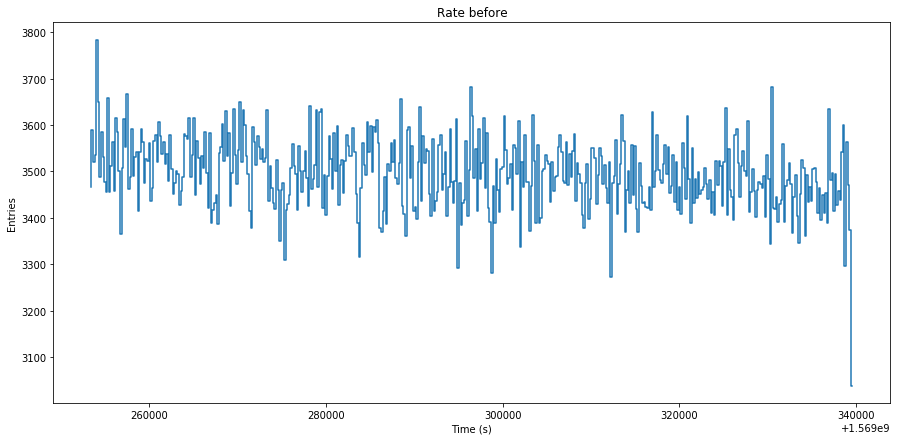

In [17]:
rate_before_hist = pd.read_hdf(histo_file_out, key='rate_before_sel')
plt.figure(figsize=(15,7));
plt.step(rate_before_hist.magnitude, rate_before_hist.entries, where='pre');
plt.xlabel('Time (s)');
plt.ylabel('Entries');
plt.title('Rate before');

# Event selection

### nS1 selection (2nd check)

In [18]:
nS1_eff_interval = (0.8, 1.)

In [19]:
store_hist = pd.HDFStore(histo_file_out, "r+", complib=str("zlib"), complevel=4)
mask_s1 = selection_nS_mask_and_checking(dst        = dst               ,
                                         column     = type_of_signal.nS1,
                                         interval   = nS1_eff_interval  ,
                                         output_f   = store_hist        ,
                                         input_mask = None              ,
                                         nbins_hist = 10                ,
                                         range_hist = (0,10)            ,
                                         norm       = True              )

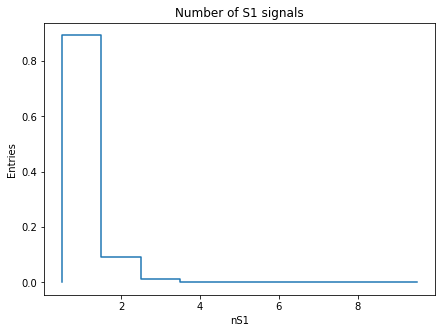

In [20]:
store_hist.close()

s1_hist = pd.read_hdf(histo_file_out, key='nS1')
plt.figure(figsize=(7,5));
plt.step(s1_hist.magnitude, s1_hist.entries, where='pre');
plt.xlabel('nS1');
plt.ylabel('Entries');
plt.title('Number of S1 signals');

In [21]:
eff = dst[mask_s1].event.nunique()/dst.event.nunique()
print('S1 selection efficiency: ', eff*100, '%')

S1 selection efficiency:  89.31811033876959 %


#### Plots

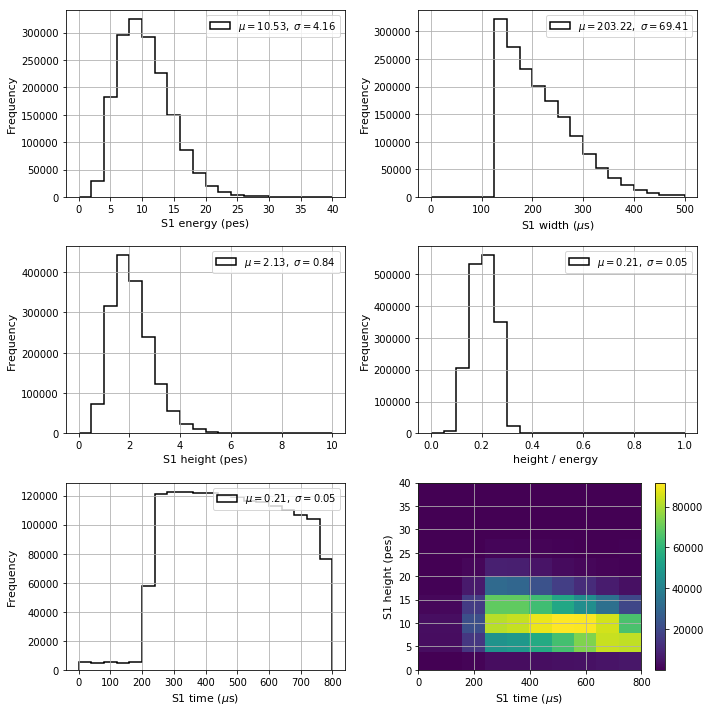

In [22]:
s1d = s1d_from_dst(dst)
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

### nS2 selection (3rd chech)

In [23]:
nS2_eff_interval = (0.9, 1.)

In [24]:
store_hist = pd.HDFStore(histo_file_out, "r+", complib=str("zlib"), complevel=4)
mask_s2 = selection_nS_mask_and_checking(dst        = dst               ,
                                         column     = type_of_signal.nS2,
                                         interval   = nS2_eff_interval  ,
                                         output_f   = store_hist        ,
                                         input_mask = mask_s1           ,
                                         nbins_hist = 10                ,
                                         range_hist = (0,10)            ,
                                         norm       = True              )

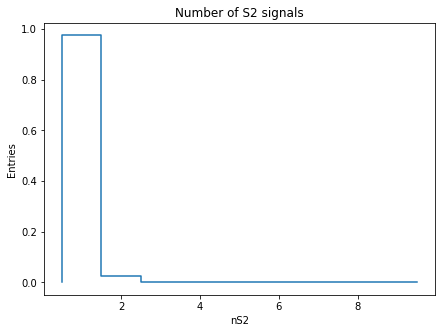

In [25]:
store_hist.close()

s2_hist = pd.read_hdf(histo_file_out, key='nS2')
plt.figure(figsize=(7,5));
plt.step(s2_hist.magnitude, s2_hist.entries, where='pre');
plt.xlabel('nS2');
plt.ylabel('Entries');
plt.title('Number of S2 signals');

In [26]:
eff = dst[mask_s2].event.nunique()/dst[mask_s1].event.nunique()
print('S2 selection efficiency: ', eff*100, '%')

S2 selection efficiency:  98.33812008317543 %


#### Plots

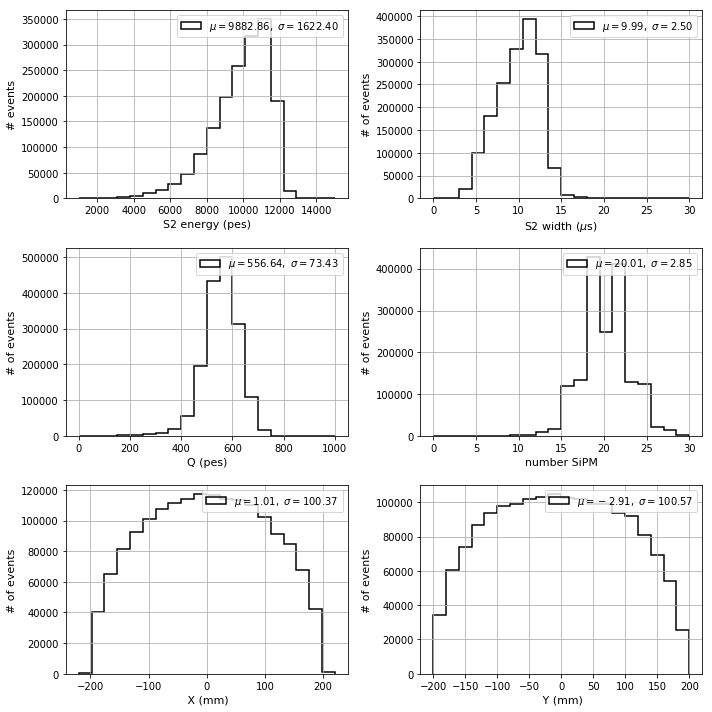

In [27]:
s2d = s2d_from_dst(dst)
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

### 4th check: Z distribution of events is correct

In [28]:
nsigmas_Zdst    = 10

In [29]:
check_Z_dst(Z_vect   = dst[mask_s2].Z  ,
            ref_hist = ref_histos.
                            Z_dist_hist,
            n_sigmas = nsigmas_Zdst    )

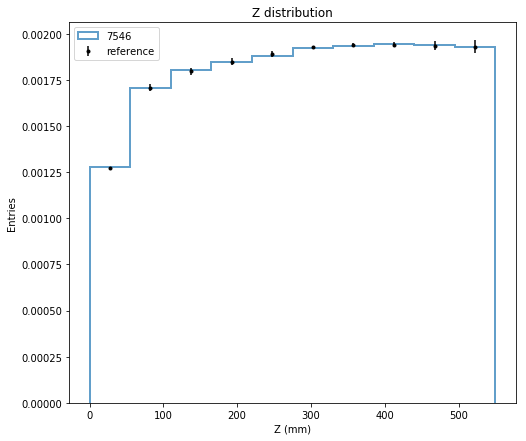

In [30]:
plt.figure(figsize=(8,7));
plt.title('Z distribution');
plt.hist(dst[mask_s2].Z, 10, (0, 550), density=1, histtype='step', alpha=0.7, linewidth=2, label=run_number);
plt.errorbar(ref_histos.Z_dist_hist.bin_centres, ref_histos.Z_dist_hist.bin_entries, yerr=ref_histos.Z_dist_hist.err_bin_entries, fmt='.k', label='reference');
plt.legend();
plt.ylabel('Entries');
plt.xlabel('Z (mm)');

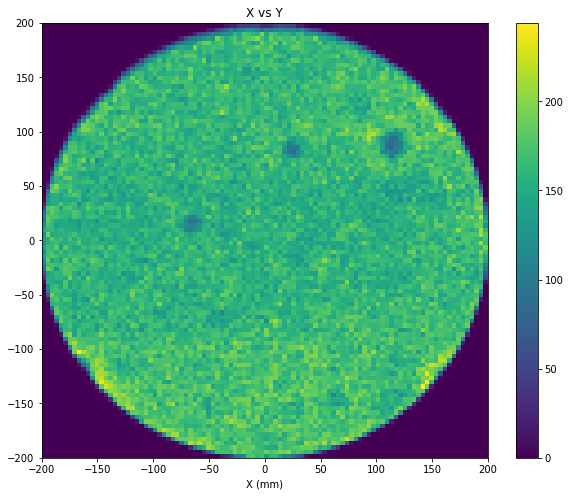

In [31]:
plt.figure(figsize=(10,8))
plt.hist2d(dst[mask_s2].X, dst[mask_s2].Y, 100, [(-200,200),(-200,200)])
plt.xlabel('X (mm)');
plt.xlabel('X (mm)');
plt.title('X vs Y');
plt.colorbar();

## Time stamps

In [32]:
from krcal.core.core_functions import time_delta_from_time
ti = get_time_series_df
ts, masks = ti(5, (dst.time.values[0],dst.time.values[-1]), dst)

In [33]:
from krcal.core.fitmap_functions              import time_fcs_df

ti = time_fcs_df
fps = ti(ts, masks, dst, 
         nbins_z = 15,
         nbins_e = 25,
         range_z = (10, 550),
         range_e = (7000, 18000),
         energy  = 'S2e',
         fit     = FitType.profile)  # fps: fit-profile series (implicit is a time series, using profile)

In [34]:
import numpy as np
def plot_time_fcs(fps       ,
                  range_chi2 = (0,10),
                  range_e0   = (8000,13500),
                  range_lt   = (2000, 4000),
                  figsize     = (12,6)):
    if fps == None:
        print('Trying to plot a null fit. Refit and try again')
        return None


    fig = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(1, 3, 1)
    (_) = plt.errorbar(fps.ts, fps.e0, fps.e0u, fmt="p")
    plt.ylim(range_e0)
    plt.xlabel('time (s)')
    plt.ylabel('e0 (pes)')
    ax  = fig.add_subplot(1, 3, 2)
    (_) = plt.errorbar(fps.ts, fps.lt, fps.ltu, fmt="p")
    plt.ylim(range_lt)
    plt.xlabel('time (s)')
    plt.ylabel('lt (mus)')
    ax  = fig.add_subplot(1, 3, 3)
    (_) = plt.errorbar(fps.ts, fps.c2, np.sqrt(fps.c2), fmt="p")
    plt.ylim(range_chi2)
    plt.xlabel('time (s)')
    plt.ylabel('chi2')
    plt.tight_layout()


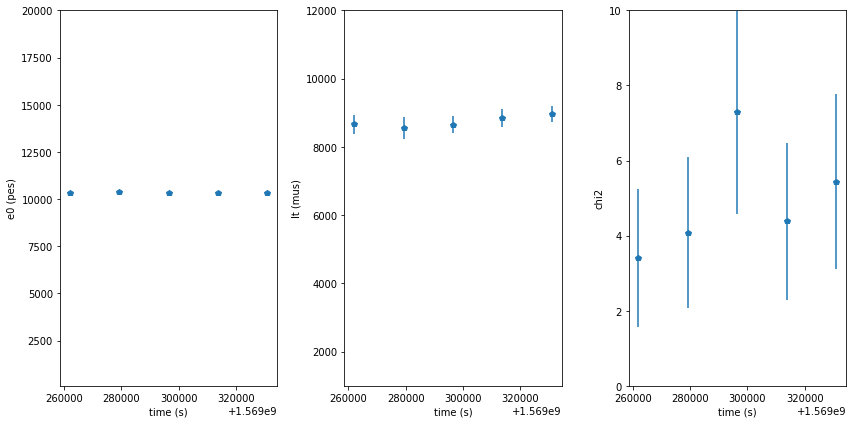

In [35]:
#from krcal.core.plt_functions import plot_time_fcs
plot_time_fcs(fps,
              range_chi2  = (0,10),
              range_e0    = (100,20000),
              range_lt    = (1000, 12000),
              figsize     = (12,6))

### Band selection (5th check)

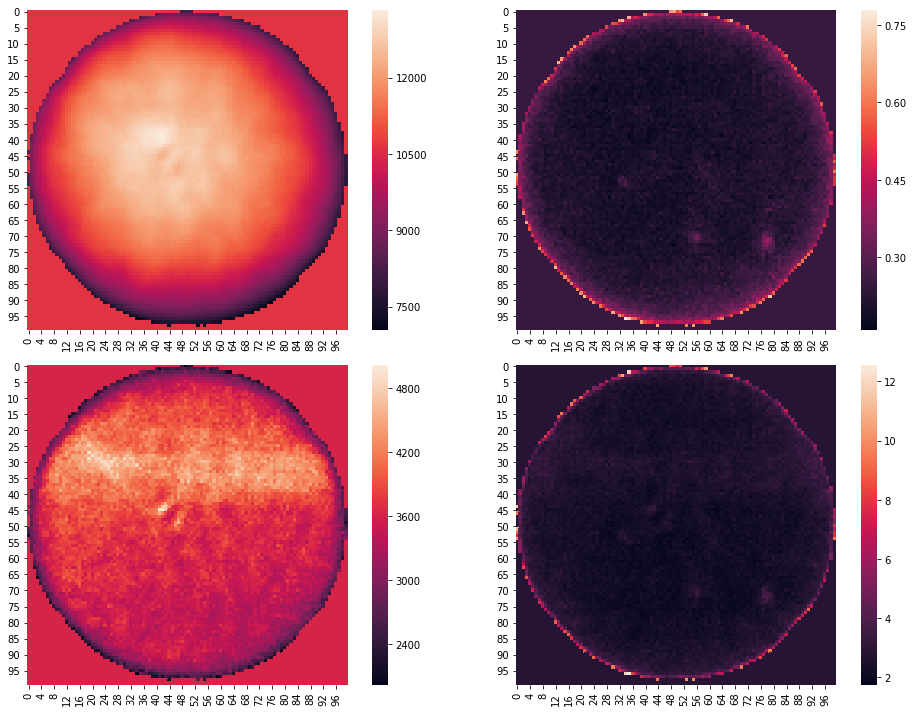

In [36]:
draw_xy_maps(bootstrapmap)

In [37]:
geom_corr = e0_xy_correction(bootstrapmap)

In [38]:
corr = geom_corr(dst[mask_s2].X, dst[mask_s2].Y)

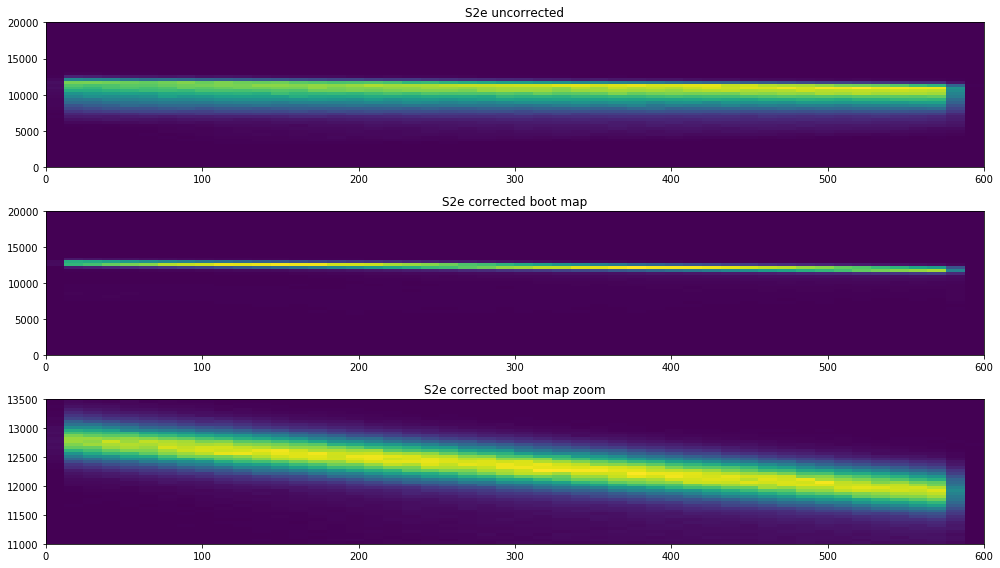

In [39]:
fig = plt.figure(figsize=(14,8))
plt.subplot(3, 1, 1)
plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e, 50, range=[[0,600],[0, 20000]]);

plt.title('S2e uncorrected')
plt.subplot(3, 1, 2)
plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e*corr, 50, range=[[0,600],[0, 20000]])
plt.title('S2e corrected boot map')

plt.subplot(3, 1, 3)
plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e*corr, 50, range=[[0,600],[11000, 13500]])
plt.title('S2e corrected boot map zoom')
plt.tight_layout()

In [40]:
band_sel_params = dict(
    range_Z     = (10, 550)      ,  # Z range to apply selection.
    range_E     = (10.0e+3,14e+3),  # Energy range to apply sel.
    nbins_z     = 50             ,  # Number of bins in Z axis.
    nbins_e     = 50             ,  # Number of bins in energy axis.
    nsigma_sel  = 3.5            ,  # Number of sigmas to apply sel.
    eff_min     = 0.90           ,  # Min eff. to continue map prod.
    eff_max     = 1.00           )  # Max eff. to continue map prod.

In [41]:
mask_band = band_selector_and_check(dst        = dst         ,
                                    boot_map   = bootstrapmap,
                                    input_mask = mask_s2     ,
                                    **band_sel_params        )

In [42]:
emaps = e0_xy_correction(bootstrapmap)
E0 = dst[mask_s2].S2e.values * emaps(dst[mask_s2].X.values, dst[mask_s2].Y.values)

sel_krband = np.zeros_like(mask_s2)
sel_krband[mask_s2], fpl, fph, hp, pp = selection_in_band(dst[mask_s2].Z,
                                                           E0,
                                                           range_z = band_sel_params['range_Z'],
                                                           range_e = band_sel_params['range_E'],
                                                           nbins_z = band_sel_params['nbins_z'],
                                                           nbins_e = band_sel_params['nbins_e'],
                                                           nsigma  = band_sel_params['nsigma_sel'])

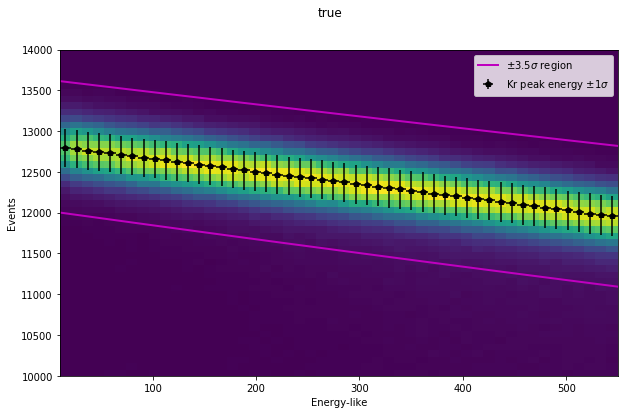

In [43]:
 plot_selection_in_band(fpl, fph, hp, pp, nsigma = band_sel_params['nsigma_sel'])

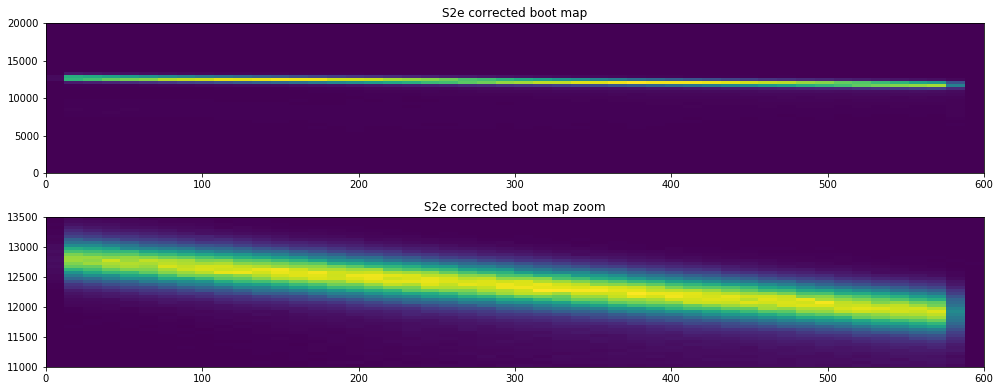

In [44]:
fig = plt.figure(figsize=(14,8))
plt.subplot(1, 1, 1)
plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e, 50, range=[[0,600],[0, 20000]]);

plt.title('S2e uncorrected')
plt.subplot(3, 1, 2)
plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e*corr, 50, range=[[0,600],[0, 20000]])
plt.title('S2e corrected boot map')

plt.subplot(3, 1, 3)
plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e*corr, 50, range=[[0,600],[11000, 13500]])
plt.title('S2e corrected boot map zoom')
plt.tight_layout()

In [45]:
eff = dst[mask_band].event.nunique()/dst[mask_s2].event.nunique()
print('Band selection efficiency: ', eff*100, '%')

Band selection efficiency:  93.72464303065865 %


In [46]:
corr_band = geom_corr(dst[mask_band].X, dst[mask_band].Y)

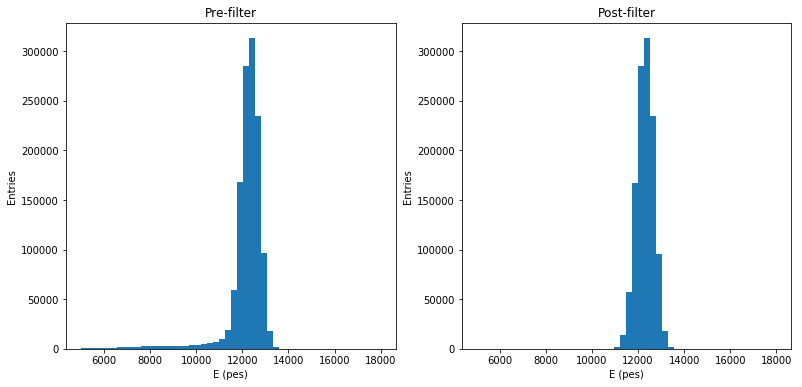

In [47]:
fig = plt.figure(figsize=(13,6))
plt.subplot(1, 2, 1)
plt.hist(dst[mask_s2].S2e*corr,  bins = 50, range =(5000,18000))
plt.title('Pre-filter');
plt.xlabel('E (pes)');
plt.ylabel('Entries');
plt.subplot(1, 2, 2)
plt.hist(dst[mask_band].S2e*corr_band,  bins = 50, range =(5000,18000))
plt.title('Post-filter');
plt.xlabel('E (pes)');
plt.ylabel('Entries');

### 6th check: rate after selection

In [48]:
n_dev_rate = 5

In [49]:
store_hist = pd.HDFStore(histo_file_out, "r+", complib=str("zlib"), complevel=4)
check_rate_and_hist(times      = dst[mask_band].time,
                    output_f   = store_hist         ,
                    name_table = "rate_after_sel"   ,
                    n_dev      = n_dev_rate         ,
                    bin_size   = 180                ,
                    normed     = False              )

In [50]:
store_hist.close()

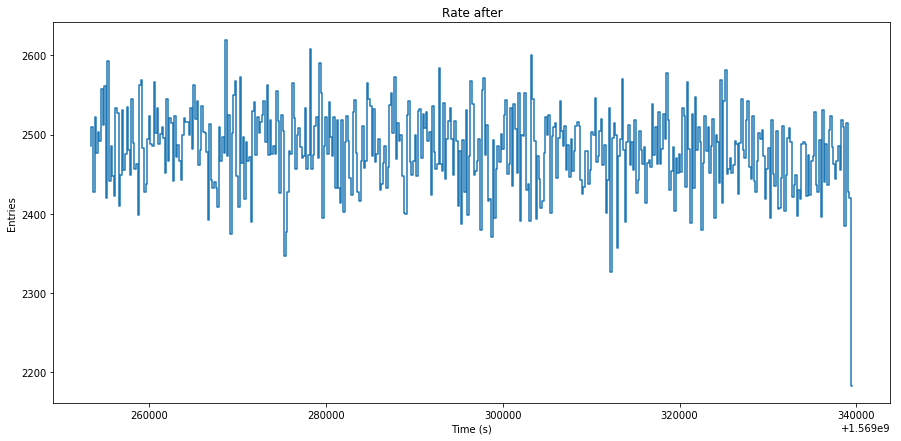

In [51]:
rate_after_hist = pd.read_hdf(histo_file_out, key='rate_after_sel')
plt.figure(figsize=(15,7));
plt.step(rate_after_hist.magnitude, rate_after_hist.entries, where='pre');
plt.xlabel('Time (s)');
plt.ylabel('Entries');
plt.title('Rate after');

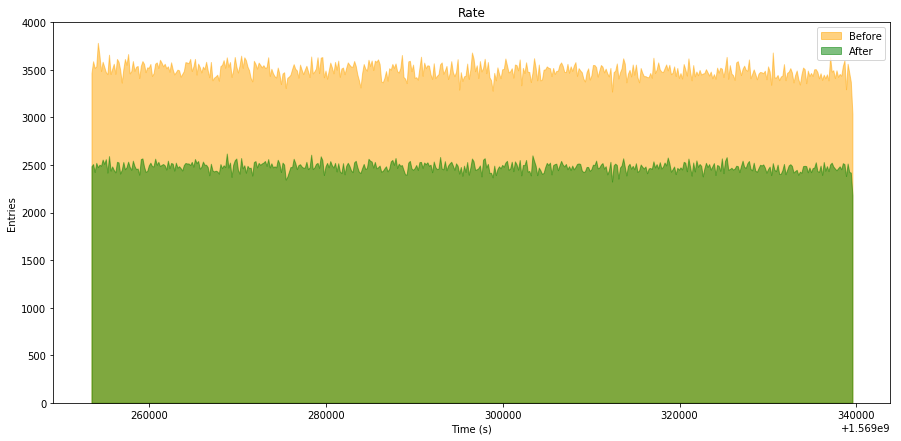

In [52]:
plt.figure(figsize=(15,7));
plt.fill_between(rate_before_hist.magnitude, rate_before_hist.entries, label='Before', color='orange', alpha=0.5);
plt.fill_between(rate_after_hist.magnitude, rate_after_hist.entries, label='After', color='green', alpha=0.5);
plt.legend();
plt.xlabel('Time (s)');
plt.ylabel('Entries');
plt.title('Rate');
plt.ylim(0, 4000);

In [53]:
sel_dst = dst[mask_band]

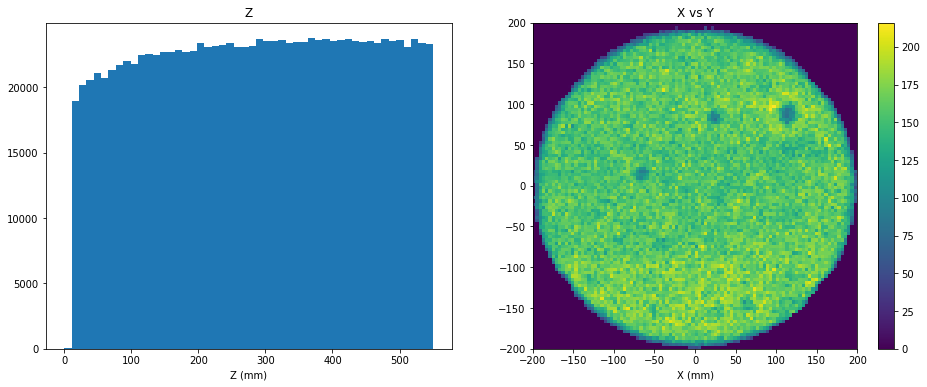

In [54]:
plt.figure(figsize=(16,6));
plt.subplot(1,2,1);
plt.hist(sel_dst.Z, bins = 50, range =(0,550))
plt.title('Z')
plt.xlabel('Z (mm)');
plt.subplot(1,2,2);
plt.hist2d(sel_dst.X, sel_dst.Y, 100, [(-200,200),(-200,200)])
plt.xlabel('X (mm)');
plt.xlabel('X (mm)');
plt.title('X vs Y');
plt.colorbar();

Now that all selection cuts and checks are passed successfully, it is time to create the correction map.

# Map production

### Selection of number of XY bins

In [55]:
thr_evts_for_sel_map_bins = 1e6
default_n_bins            = None

- If the number of evts is greater than 1e6 -> 100x100 map
- If the number of evts is lower than 1e6 -> 50x50 map

In [56]:
number_of_bins = get_binning_auto(nevt_sel                = sel_dst.event.nunique()  ,
                                  thr_events_for_map_bins = thr_evts_for_sel_map_bins,
                                  n_bins                  = default_n_bins           )

In [57]:
print('Number of XY bins: ', number_of_bins, '(', sel_dst.event.nunique(), 'events)')

Number of XY bins:  100 ( 1188331 events)


## Map computation

In [58]:
map_params        = dict(
    nbins_z       = 15            ,
    nbins_e       = 25            ,
    z_range       = (10, 550)     ,
    e_range       = (2000, 18000) ,
    chi2_range    = (0,10)        ,
    lt_range      = (1000, 15000) ,
    nmin          = 100           ,
    maxFailed     = 600           ,
    r_max         = 200           ,
    r_fid         = 100           ,
    nStimeprofile = 1800          ,
    x_range       = (-200,200)    ,
    y_range       = (-200,200)    )

In [59]:
maps = calculate_map(dst        = sel_dst                 ,
                     XYbins     = (number_of_bins         ,
                                   number_of_bins)        ,
                     nbins_z    = map_params['nbins_z']   ,
                     nbins_e    = map_params['nbins_e']   ,
                     z_range    = map_params['z_range']   ,
                     e_range    = map_params['e_range']   ,
                     chi2_range = map_params['chi2_range'],
                     lt_range   = map_params['lt_range']  ,
                     fit_type   = FitType.unbined         ,
                     nmin       = map_params['nmin']      ,
                     x_range    = map_params['x_range']   ,
                     y_range    = map_params['y_range']   )

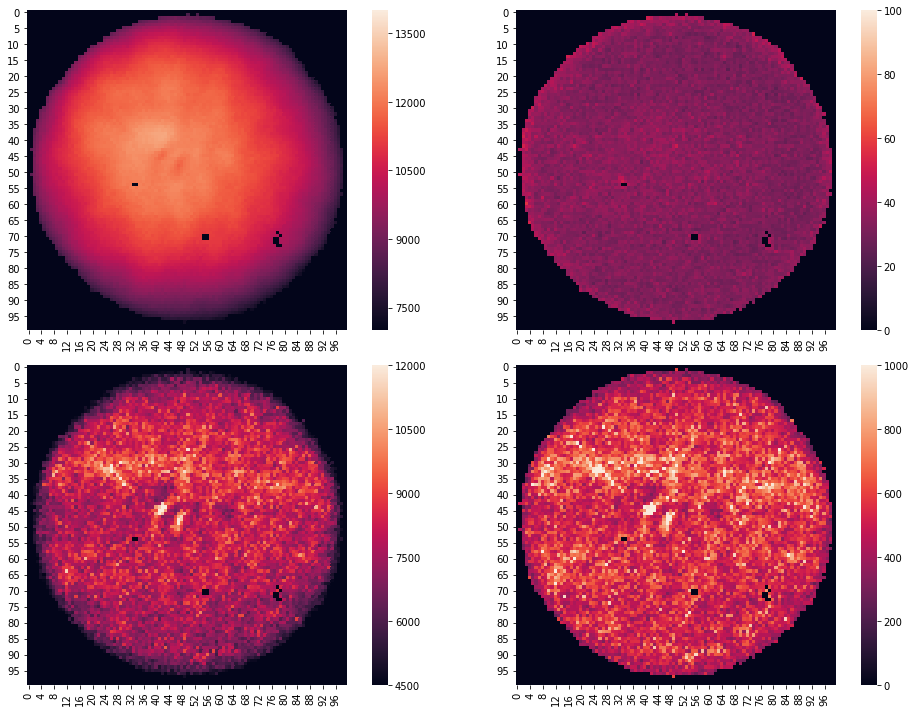

In [61]:
draw_xy_maps(maps,
             e0lims  = (7000, 14000),
             ltlims  = (4500, 12000),
             eulims  = (0.0,  100),
             lulims  = (0, 1000),
             figsize=(14,10))

### Last check: number of failed fits

In [62]:
maxFailed = map_params['maxFailed']
r_max = map_params['r_max']

In [63]:
check_failed_fits(maps      = maps          ,
                  maxFailed = maxFailed     ,
                  nbins     = number_of_bins,
                  rmax      = r_max         ,
                  rfid      = r_max         )

### chi2 regularization

In [64]:
chi2_range = map_params['chi2_range']

In [65]:
regularized_maps = regularize_map(maps    = maps,
                                  x2range = chi2_range)

And compute relative error maps, instead of absolute error.

In [66]:
regularized_maps = relative_errors(am = regularized_maps)

Now, the outer bins are replaced by nans:

In [67]:
regularized_maps = remove_peripheral(map   = regularized_maps,
                                     nbins = number_of_bins  ,
                                     rmax  = r_max           ,
                                     rfid  = r_max           )

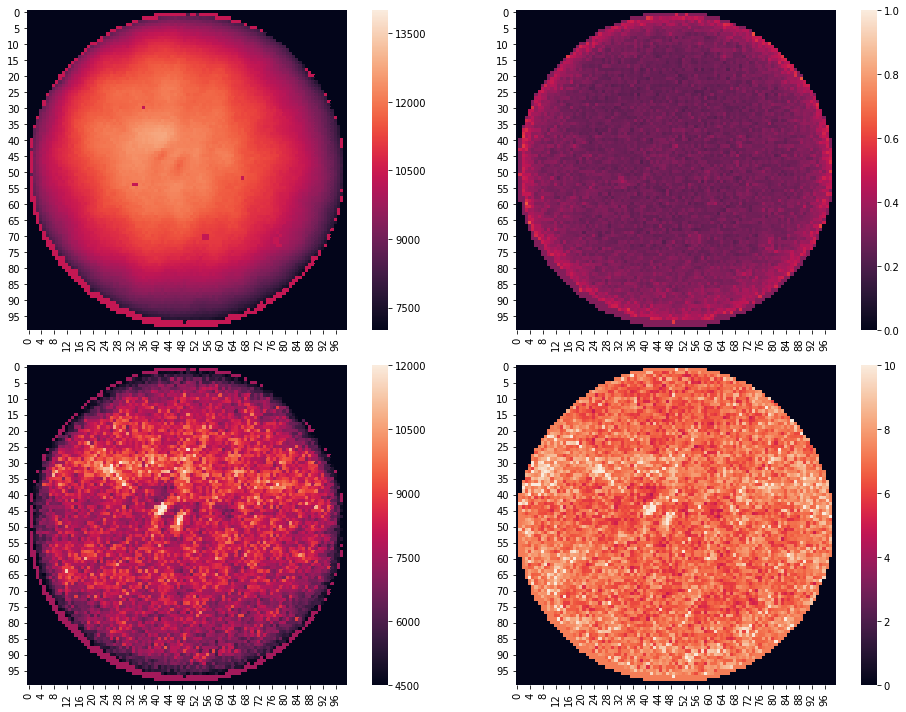

In [68]:
draw_xy_maps(regularized_maps,
             e0lims  = (7000, 14000),
             ltlims  = (4500, 12000),
             eulims  = (0.0,  1),
             lulims  = (0, 10),
             figsize=(14,10))

### Mapinfo table is added

In [69]:
maps = add_mapinfo(asm        = regularized_maps     ,
                   xr         = map_params['x_range'],
                   yr         = map_params['y_range'],
                   nx         = number_of_bins       ,
                   ny         = number_of_bins       ,
                   run_number = run_number           )

In [70]:
maps.mapinfo

xmin          -200
xmax           200
ymin          -200
ymax           200
nx             100
ny             100
run_number    7546
dtype: int64

### Temporal evolution table is added

In [71]:
r_fid = map_params['r_fid']
nStimeprofile = map_params['nStimeprofile']

In [72]:
add_krevol(maps          = maps                 ,
           dst           = sel_dst              ,
           r_fid         = r_fid                ,
           nStimeprofile = nStimeprofile        ,
           x_range       = map_params['x_range'],
           y_range       = map_params['y_range'],
           XYbins        = (number_of_bins      ,
                            number_of_bins     ))

In [73]:
temp = maps.t_evol

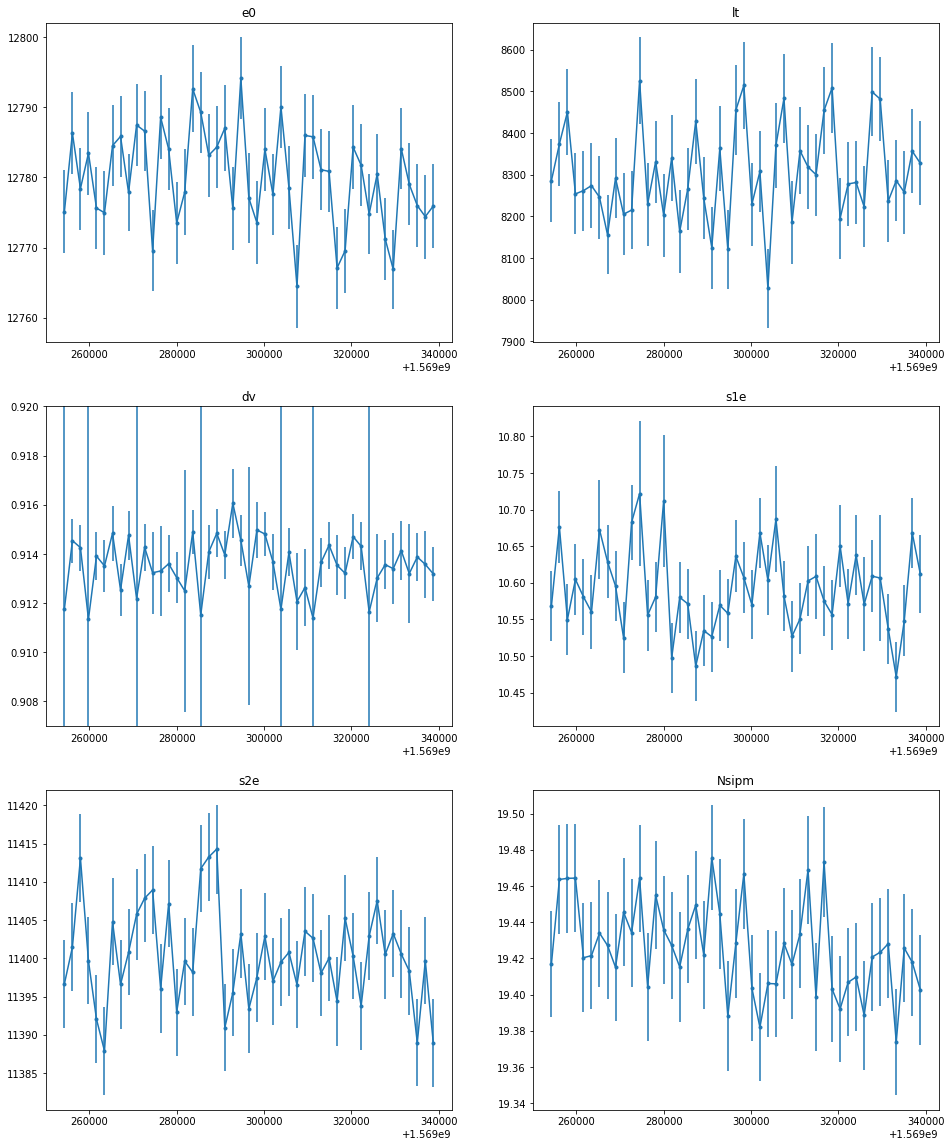

In [74]:
plt.figure(figsize=(16, 20));
plt.subplot(3,2,1);
plt.title('e0');
plt.errorbar(temp.ts, temp.e0, temp.e0u, fmt='.', linestyle='-');
plt.subplot(3,2,2);
plt.title('lt');
plt.errorbar(temp.ts, temp['lt'], temp['ltu'], fmt='.', linestyle='-');
plt.subplot(3,2,3);
plt.title('dv');
plt.ylim(0.907, 0.920);
plt.errorbar(temp.ts, temp.dv, temp.dvu, fmt='.', linestyle='-');
plt.subplot(3,2,4);
plt.title('s1e');
plt.errorbar(temp.ts, temp.s1e, temp.s1eu, fmt='.', linestyle='-');
plt.subplot(3,2,5);
plt.title('s2e');
plt.errorbar(temp.ts, temp.s2e, temp.s2eu, fmt='.', linestyle='-');
plt.subplot(3,2,6);
plt.title('Nsipm');
plt.errorbar(temp.ts, temp.Nsipm, temp.Nsipmu, fmt='.', linestyle='-');

# Writing final map

In [75]:
write_complete_maps(asm      = maps        ,
                    filename = map_file_out)

## Checking the map is saved properly

In [76]:
final_map = read_maps(map_file_out)

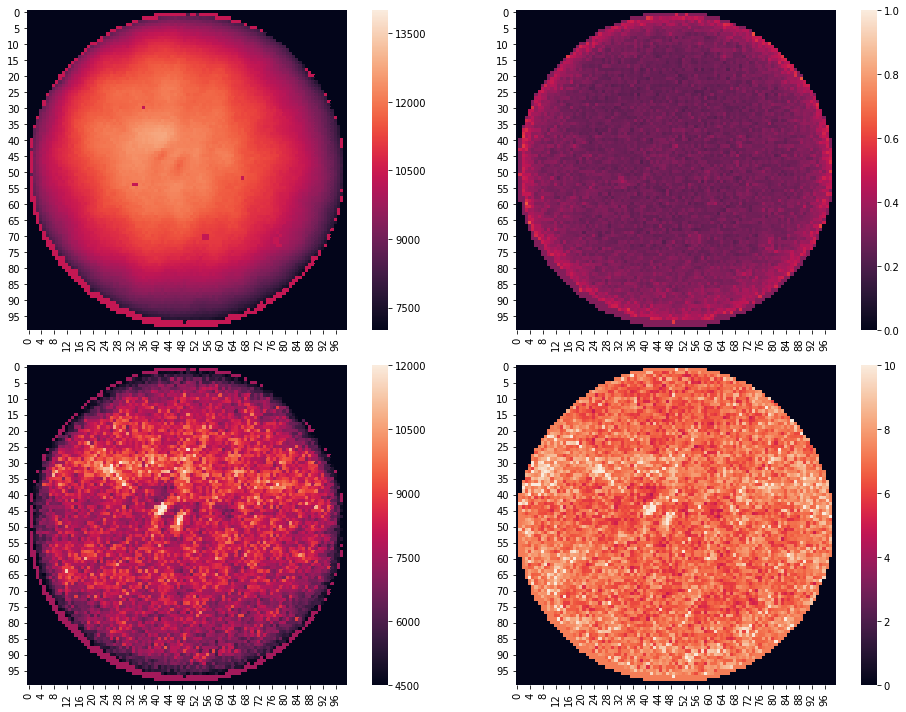

In [77]:
draw_xy_maps(final_map,
             e0lims  = (7000, 14000),
             ltlims  = (4500, 12000),
             eulims  = (0.0,  1),
             lulims  = (0, 10),
             figsize=(14,10))

### Checking that corrections work properly

In [78]:
sel_dst = sel_dst[sel_dst.R<170]

In [79]:
total_correction    = apply_all_correction(final_map, apply_temp=True)

In [80]:
corr_geo = geom_corr(sel_dst.X, sel_dst.Y)
corr_tot = total_correction(sel_dst.X, sel_dst.Y, sel_dst.Z, sel_dst.time)

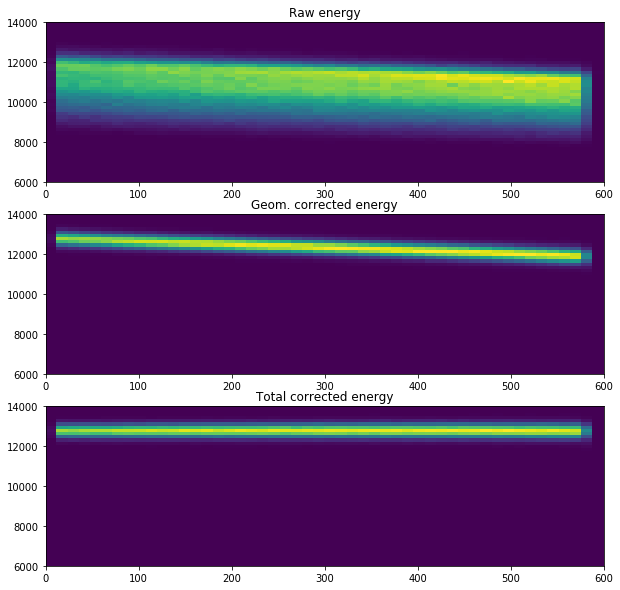

In [81]:
fig = plt.figure(figsize=(10,10))
plt.subplot(3, 1, 1)
plt.hist2d(sel_dst.Z, sel_dst.S2e, 50, [(0,600),(6000,14000)])
plt.title('Raw energy');
plt.subplot(3, 1, 2)
plt.hist2d(sel_dst.Z, sel_dst.S2e*corr_geo, 50, [(0,600),(6000,14000)])
plt.title('Geom. corrected energy');
plt.subplot(3, 1, 3)
plt.hist2d(sel_dst.Z, sel_dst.S2e*corr_tot, 50, [(0,600),(6000,14000)])
plt.title('Total corrected energy');

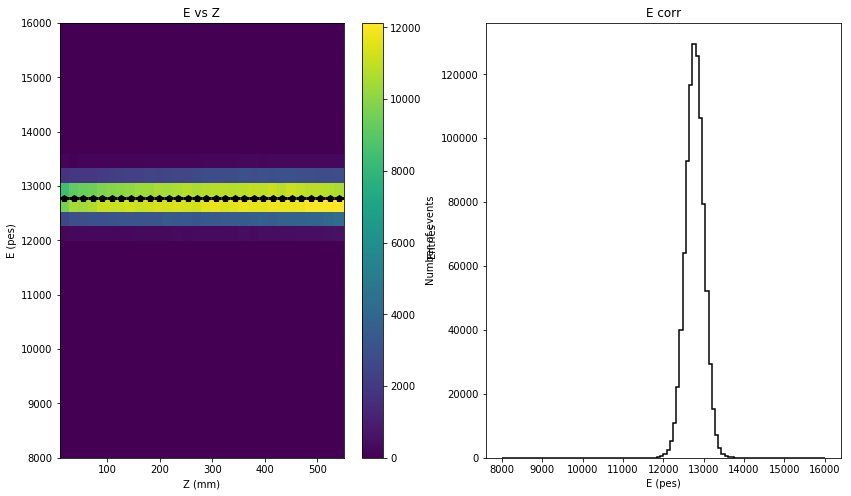

In [82]:
e_range = (8000,16000)
zrange = (10,550)
fig = plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)

nevt = h2(sel_dst.Z, sel_dst.S2e*corr_tot, 30, 30, zrange, e_range, profile=True)
plt.xlabel('Z (mm)');
plt.ylabel('E (pes)');
plt.title('E vs Z');

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(sel_dst.S2e*corr_tot,  bins = 100, range =e_range, stats=True, lbl = 'E')
plt.xlabel('E (pes)');
plt.ylabel('Entries');
plt.title('E corr');

  Fit was valid = True
 Emu       = 12779.511239707123 +-0.23780691946888446 
 E sigma   = 223.14083215687154 +-0.1802489859510383 
 chi2    = 2.216742720356583 
 sigma E/E (FWHM)     (%) =4.1032942945372435
 sigma E/E (FWHM) Qbb (%) =0.529948485594969 


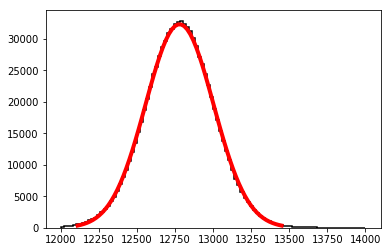

In [83]:
fc = fit_energy(sel_dst.S2e*corr_tot, nbins=100, range=(12000, 14000))
plot_fit_energy(fc)
print_fit_energy(fc)

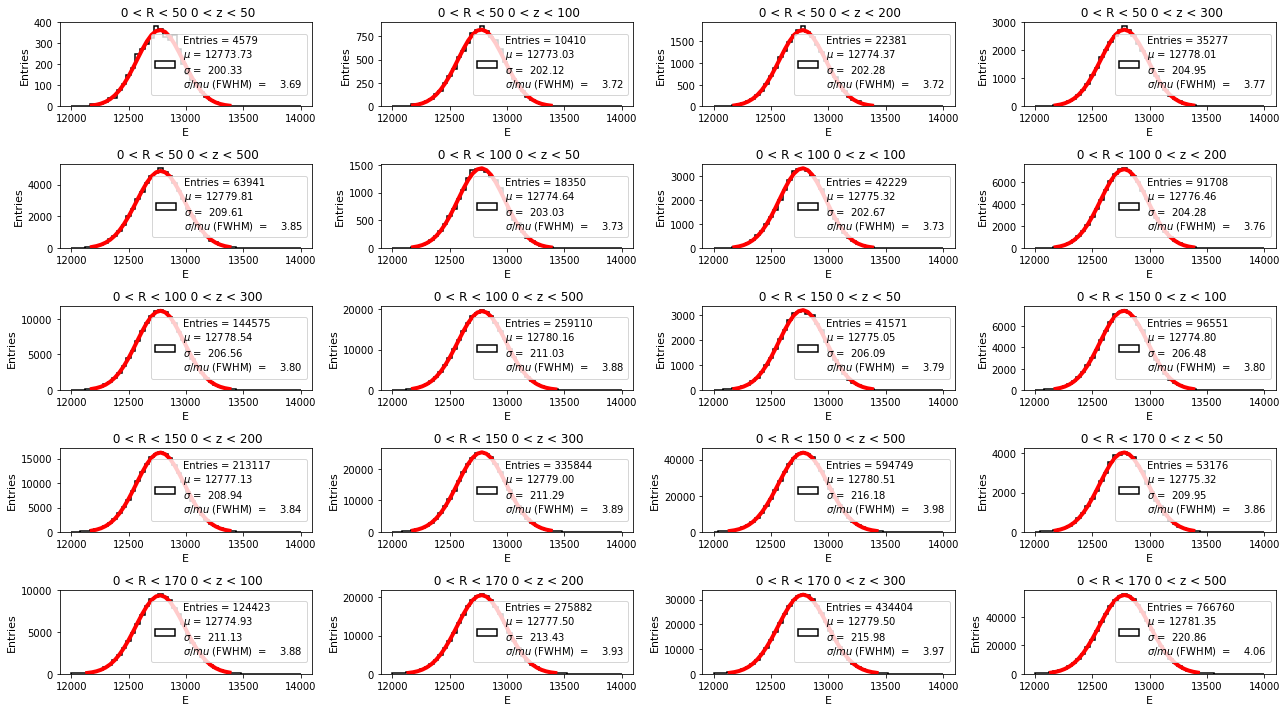

In [84]:
Ri = (50, 100,150,170)
Zi = (50, 100,200,300,500)

FC, FCE = resolution_r_z(Ri, Zi, sel_dst.R, sel_dst.Z, sel_dst.S2e*corr_tot,
                    enbins = 50,
                    erange = (12000,14000),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10)) 

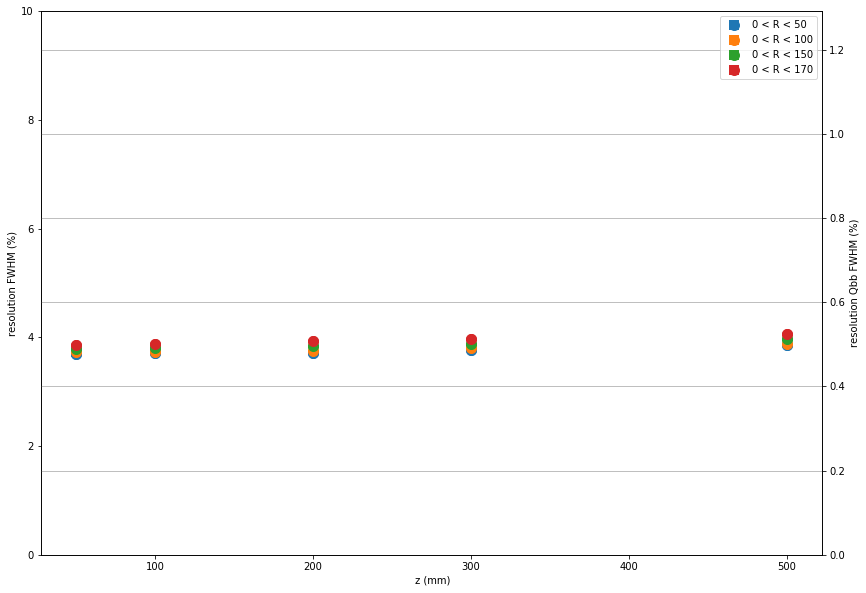

In [85]:
plot_resolution_r_z(Ri, Zi, FC, FCE, r_range=(0,10))

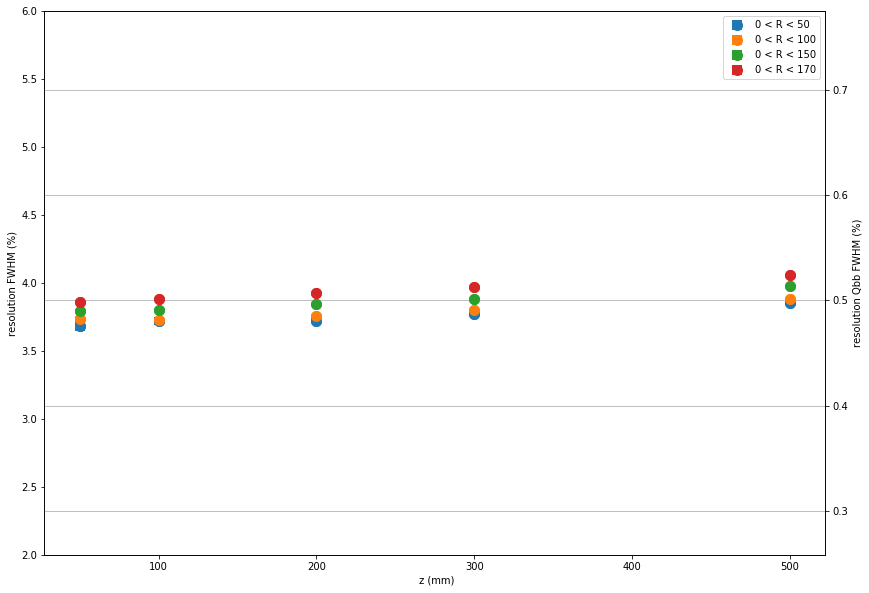

In [86]:
plot_resolution_r_z(Ri, Zi, FC, FCE, r_range=(2,6))